# LAB 3.1 — Lane Geometry Estimation from Bird’s-Eye-View Mask
ACE Lane-Keeping System – Geometry Module  

## 1. Overview
This lab covers the **core geometric computations** that convert a binary lane mask (from BEV) into:

- Lateral offset of the vehicle (`pos_m`)
- Heading deviation (`head_deg`)
- Multi-ratio sampling across the lane
- Adaptive selection of the most reliable ratio

These outputs form the **input to the Adaptive Lane Controller** used in LAB 3.3.


## 2. Learning Objectives

After this lab, learner will understand:

1. How to compute lane center from BEV mask  
2. How to estimate heading using two vertical sampling points  
3. How to convert pixel width → real-world meters  
4. How multi-ratio improves robustness  
5. How to evaluate stability using windowed statistics  


## 3. Import Libraries


In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import deque

## 4. Load BEV Mask (Input from LAB 2)

In real deployment, this mask is generated from:

mask01 → ROI → morphology → BEV

For this lab, we load a sample BEV binary mask.

In [ ]:
bev = cv2.imread(r"C:\Users\admin\ACE_Finalv3\debug_pipeline_out\frame_00600_4_bev.png", cv2.IMREAD_GRAYSCALE)
bev = (bev > 0).astype(np.uint8)

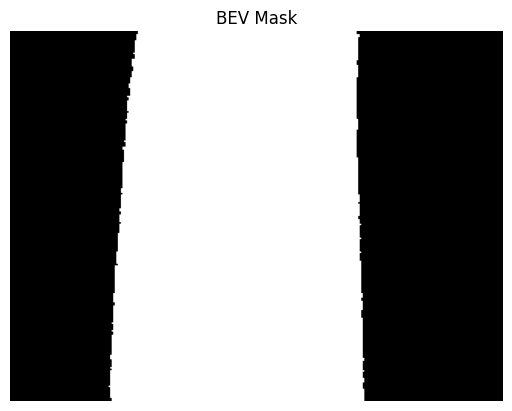

In [21]:
plt.imshow(bev, cmap='gray')
plt.title("BEV Mask")
plt.axis('off')
plt.show()

## 5. Compute Lane Width Scaling (meters_per_pixel)

To convert pixel distances into meters, we estimate lane width from the bottom row:

$$
meters\_per\_pixel = \frac{lane\_width\_m}{lane\_width\_px}
$$

We assume the physical lane width is **0.20 m** (Autocar-Kit specification).


In [ ]:
def meters_per_pixel(bev, lane_width_m=0.20):
    """
    Estimate meters-per-pixel (mpp) at the bottom row of BEV mask.
    - bev: binary BEV mask
    - lane_width_m: real-world lane width in meters (default 0.20m for minicar)
    """

    H, W = bev.shape
    row = bev[H - 1, :]
    xs = np.where(row > 0)[0]        # lane pixel indices


    if xs.size >= 2:
        # TODO: compute lane width in pixels
        ### YOUR CODE HERE ###
        # width_px = ?

        # TODO: denoise if width is too small (<16 px)
        ### YOUR CODE HERE ###
        # width_px = max(width_px, ...)

        # TODO: convert to meters per pixel
        ### YOUR CODE HERE ###
        # mpp = ?

        return mpp

    # Lane not detected → fallback
    return lane_width_m / max(W, 1)


## 6. Compute Lane Center Position (center_x)

After computing the lane width scaling (meters-per-pixel), the next step is to
measure the **horizontal center of the lane** at a given height in the BEV image.

For a given ratio ( r in (0,1) ):

$$
y = r \cdot H
$$

We scan the BEV mask at row \( y \) and find lane pixels:

$$
x_{\text{lane}} = \{\, x \mid bev[y, x] = 1 \,\}
$$

If at least two lane pixels exist:

$$
x_{\text{center}} = \frac{x_{\min} + x_{\max}}{2}
$$

Otherwise, we return **NaN**, indicating that the lane is not visible at that height.


In [ ]:
def center_x(bev, ratio):
    """
    Compute the horizontal center of the lane at a given height ratio.
    
    Parameters:
    - bev: binary BEV mask (0/1)
    - ratio: vertical position ratio (0 = top, 1 = bottom)
    
    Returns:
    - cx: lane center x-coordinate (float), or NaN if lane is not visible
    """

    H, W = bev.shape
    # Convert ratio to a valid row index
    y = int(ratio * H)
    y = np.clip(y, 0, H - 1)
    # Find lane pixels in this row
    xs = np.where(bev[y, :] > 0)[0]

    if xs.size < 2:
        return np.nan 

    # TODO 1: compute lane center x-coordinate
    ### YOUR CODE HERE ###
    # cx = 

    return cx


## 7. Compute Lateral Lane Offset (posₘ)

After obtaining:

1. **Lane center** $( x_{\text{center}} $) from Cell 6
2. **Meters-per-pixel** $( mpp $) from Cell 5

we can compute the **lateral deviation** of the vehicle from the lane center.

Let the BEV image width be \( W \).  
The reference center of the vehicle is:

$$
x_{\text{ref}} = \frac{W}{2}
$$

The lateral offset in meters is:

$$
pos_m = (x_{\text{ref}} - x_{\text{center}})\,\times\, mpp
$$

Interpretation:
- $( pos_m > 0 $): vehicle is **left** of center → needs to steer **right**
- $( pos_m < 0 $): vehicle is **right** of center → needs to steer **left**

If lane center cannot be detected, return `NaN`.


In [ ]:
def compute_lateral_offset(bev, ratio, mpp):
    """
    Compute lateral offset (pos_m) using:
        - BEV mask
        - center ratio (0–1)
        - meters-per-pixel (mpp)

    Returns:
        pos_m (float), or NaN if lane not detected.
    """

    H, W = bev.shape
    # Step 1: get lane center at this height
    cx = center_x(bev, ratio)
    if np.isnan(cx):
        return np.nan
    # Step 2: compute reference vehicle center
    ### YOUR CODE HERE ###
    # x_ref = ?

    # Step 3: compute lateral offset pos_m
    ### YOUR CODE HERE ###
    # pos_m = (x_ref - cx) * mpp

    return pos_m


## 8. Compute Heading Angle (θ) from BEV Geometry

To estimate the steering direction, we compute the **heading angle** of the lane based on
two points sampled at different heights of the BEV mask.

Let:

- $( y_b $) = lower sampling row  
- $( y_t $) = upper sampling row  
- $( x_b $) = lane center at $( y_b $)  
- $( x_t $) = lane center at $( y_t $)

We define:

$$
dx = x_b - x_t, \qquad dy = y_b - y_t
$$

The heading angle in degrees is:

$$
\theta = \arctan2(dx,\, dy) \cdot \frac{180}{\pi}
$$

Interpret:

- $( \theta > 0 $): lane curves **left**  
- $( \theta < 0 $): lane curves **right**  
- If either center is missing → return `NaN`

This is the same geometric formula used in major lane detection papers and is also
the one applied in your full pipeline.


In [ ]:
def heading_deg_at_ratio(bev, y_ratio, dy_px=30):

    """
    Compute heading angle from BEV using two sampling heights.
    
    Inputs:
        bev: BEV binary mask
        y_ratio: sampling position (0 = top, 1 = bottom of BEV)
        dy_px: vertical distance (px)
    Returns:
        heading_deg (float) or NaN,  xb : float
    """
    H, W = bev.shape
    # 1. Convert ratios → pixel coordinates
    yb = int(np.clip(y_ratio * H, 0, H - 1))
    yt = int(np.clip(yb - dy_px, 0, H - 1))
    # 2. Compute lane centers at the two heights
    xb = center_x(bev, yb / H)    # center at bottom position
    xt = center_x(bev, yt / H)    # center at upper position
    # TODO: compute dx, dy
    ### YOUR CODE HERE ###
    # dx = ?
    # dy = ?

    # TODO: compute heading angle in degrees using arctan2
    ### YOUR CODE HERE ###
    # heading_deg = ?

    return heading_deg, xb


## 9. Multi-Ratio Sampling (Extracting multiple measurements along the BEV)

A single measurement point (single-ratio) is often not stable enough, especially when:
- the lane is noisy
- part of the lane is missing
- the curve is sharp

Solution: **Sample multiple points at different positions in the BEV image** (multi-ratio sampling).

Given the set of sampling ratios:

$$
R = \{ r_1, r_2, r_3, \ldots \}
$$

At each ratio $( r_i $):

1. Extract lane center:
$$
x_i = center\_x(BEV, r_i)
$$

2. Compute lateral offset:
$$
pos_i = (W/2 - x_i) \cdot mpp
$$

3. Compute heading angle:
$$
head_i = heading(r_i)
$$

Result: the lists `pos_list`, `head_list`, `center_list` are used by the adaptive controller.


In [ ]:
def multi_ratio_measure(bev, ratios, dy_px=30, lane_width_m=0.20):
    """
    Perform multi-height lane measurements on BEV mask.

    Inputs:
        bev: BEV mask (0/1)
        ratios: list of sampling ratios (e.g., [0.98, 0.92, 0.82, 0.72])
        dy_px: vertical offset for heading calculation
        lane_width_m: physical lane width (20 cm for Autocar-Kit)

    Returns:
        centers_px: list of center-x positions at each ratio
        pos_list:   lateral offset (meters)
        head_list:  heading angle (degrees)
    """

    H, W = bev.shape

    # Meters-per-pixel scaling
    mpp = meters_per_pixel(bev, lane_width_m=lane_width_m)

    centers_px = []
    pos_list   = []
    head_list  = []

    for r in ratios:

        # TODO: Compute lane center in pixels
        ### YOUR CODE HERE ###
        # cx = center_x(bev, r)

        # TODO: Compute heading angle
        ### YOUR CODE HERE ###
        # head_deg, _ = ...

        # TODO: Compute lateral offset pos (m)
        ### YOUR CODE HERE ###
        # pos_m = ...

        centers_px.append(cx)
        pos_list.append(pos_m)
        head_list.append(head_deg)

    return centers_px, pos_list, head_list


In [ ]:
ratios = [0.98, 0.92, 0.82, 0.72]

centers_px, pos_list, head_list = multi_ratio_measure(
    bev, ratios=ratios, dy_px=30, lane_width_m=0.20
)

assert len(centers_px) == len(ratios)
assert len(pos_list)   == len(ratios)
assert len(head_list)  == len(ratios)

print("Multi-ratio measurement PASS ✔")
centers_px, pos_list, head_list

In [ ]:
H = bev.shape[0]

plt.figure(figsize=(6,6))
plt.imshow(bev * 255, cmap="gray", origin="upper")

for i, cx in enumerate(centers_px):
    if not np.isnan(cx):
        y = int(ratios[i] * H)
        plt.scatter(cx, y, s=60, label=f"r={ratios[i]:.2f}")

plt.gca().invert_yaxis()
plt.title("Multi-Ratio Lane Sampling (BEV)")
plt.legend()
plt.show()


## 10. Adaptive Ratio Selection

In the previous Multi-Ratio Cell, we extracted:
- `centers_px[r]` — lane center in pixels
- `pos_list[r]` — lateral offset in meters
- `head_list[r]` — lane heading angle

But each ratio $( r $) has different reliability:

- Some ratios see the lane clearly → stable center  
- Some ratios suffer noise or broken lanes → strong fluctuations  
- Some heights may temporarily lose the lane

Therefore, we need the **Adaptive Selection** algorithm to automatically choose the best ratio each frame.


### 1) Stability evaluation features

For each ratio $( r $):

#### ● Fluctuation of pos
$$
std\_pos = \mathrm{STD}(pos[r])
$$
Lower fluctuation → more stable → higher priority

#### ● Mean deviation of head
$$
mean\_head = \mathrm{MEAN}(head[r])
$$
A larger absolute value suggests possible noise or incorrect curvature estimation.

#### ● Visibility level (coverage)
$$
coverage = \mathrm{MEAN}(valid[r])
$$
This is the fraction of frames where the lane is visible at that position.


### 2) Meaning of W_STAB, W_HEAD, W_LAT, EPS

These are **weights used to balance stability – reliability – sampling depth**.

##### `W_STAB` — weight prioritizing stability
A large value (e.g., 2.0) means we prioritize **stable pos**, avoiding vibration or sudden center jumps.  
- Reason: ratios that give stable geometry result in more stable lane-keeping.

##### `W_HEAD` — penalty for large heading deviation
A small value (e.g., 0.1) because heading is very sensitive and should not be penalized too heavily.  
- Reason: heading naturally varies in curves → should not be punished too aggressively.

##### `W_LAT` — penalty for very high (far) ratios
A small value (0.05) used to avoid selecting regions too far away in the BEV.  
- Reason: near-field ratios give more reliable steering for stability.

##### `EPS` — anti-division-by-zero term
$$
std\_pos + \epsilon
$$
Very small (1e-6) to prevent division by zero when std_pos = 0 (perfect stability).


### 3) Combined scoring formula

$$
score(r) = 
coverage \left(
\frac{W_{stab}}{std\_pos + \epsilon} 
- W_{head} \cdot |mean\_head|
\right)
- 
W_{lat} (1 - r)
$$

Meaning:

- **more stable signal** → higher score  
- **larger heading deviation** → mild penalty  
- **lower r (closer to vehicle)** → less noise  
- **low coverage** → strong penalty (lane missing)


### 4) Optimal ratio

$$ 
r^* = \arg\max_{r} \; score(r)
$$

We then take pos & head corresponding to $( r^* $) for the controller.

→ Result: smoother, more stable, and noise-resistant vehicle behavior.


In [ ]:
W_STAB, W_HEAD, W_LAT, EPS = 2.0, 0.1, 0.05, 1e-6

def adaptive_select_student(centers_px, pos_list, head_list, ratios, WIN = 15):
    """
    Student Version.
    Only uses the data already computed from the Multi-Ratio Cell.
    """

    # TODO: create a simple history window
    ### YOUR CODE HERE ###
    # hist_pos = ...
    # hist_head = ...
    # hist_ok = ...

    # TODO: compute score for each ratio
    scores = []
    for i, r in enumerate(ratios):
        ### YOUR CODE HERE ###
        # std_pos = ...
        # mean_head = ...
        # coverage = ...
        # score = ...
        scores.append(0)  # placeholder

    # TODO: select the best ratio
    ### YOUR CODE HERE ###
    # best_idx = ...

    return {
        "best_ratio": ratios[best_idx],
        "pos": pos_list[best_idx],
        "head": head_list[best_idx],
        "scores": scores
    }


In [11]:
best_idx = select_best_ratio(pos_list, head_list, ratios)

print("Best Ratio      :", ratios[best_idx])
print("Selected pos_m  :", pos_list[best_idx])
print("Selected head   :", head_list[best_idx])


Best Ratio      : 0.82
Selected pos_m  : 0.015337423312883437
Selected head   : 0.0


## 11. Summary

In this lab, you implemented:

- Lane width estimation in meters  
- Center extraction from BEV mask  
- Compute Lateral Lane Offset (posₘ)
- Compute Heading Angle (θ)
- Multi-ratio sampling  
- Adaptive selection of the best ratio  

These outputs feed directly into:

**LAB 3.2 – Temporal Stability & EMA Filtering**  
**LAB 3.3 – Adaptive Steering Control + Video Demo**
